## Imports

In [1]:
!pip -q install numpy scipy matplotlib tensorflow==2.11.0 tensorflow-datasets==4.8.3 tensorflow-probability==0.19.0 deeptrack==1.5.5
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.2/186.2 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 27.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 57.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import expon


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11063483152832728383
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40119107584
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13136439065558645540
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

## 1. Stimulus

In [3]:
# Parameters:
IMAGE_SIZE = 180

POSITION_RANGE = 1.5

CR_SIGMA_RANGE = [1, 30]
GAUSS_AMPLITUDE_RANGE = [2, 20000]

NOISE_SD_RANGE = [0, 30]

BACKGROUND_LUM_EXP_LOC = 1.
BACKGROUND_LUM_EXP_SCALE = 10.
BG_LUMINANCE_RANGE = [.125, .6]

plt.rcParams['figure.figsize'] = [8, 8]


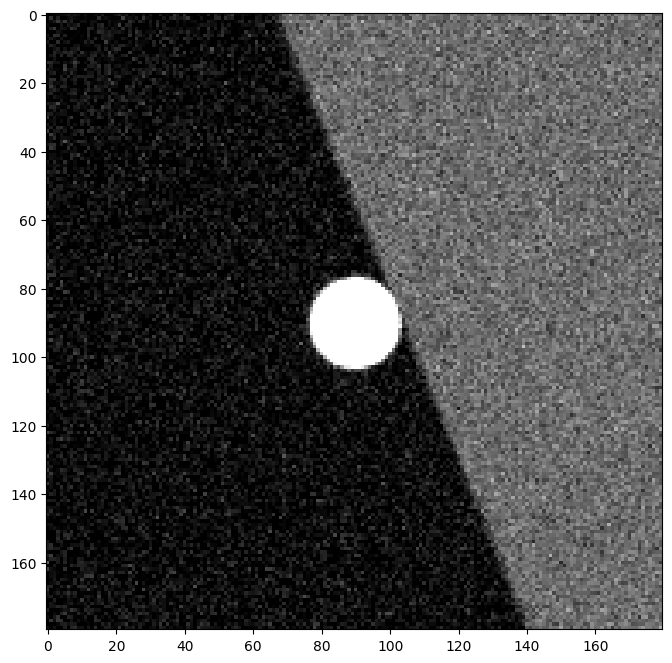

position: [89.85928316 90.05203417], gray_extent: None, cr_sigma: [13.12670164], gauss_amp: [8672.08761184], noise_sigma: [13.12670164]


In [4]:
def drawFromRange(range, n=1):
    # range - list of length 2, e.g., [1, 2]
    return range[0] + np.random.rand(n) * np.diff(range)

# inverse unnormalized Gaussian for scaling
def gauss1d_inv(v=0,mx=0,sx=1):
    return mx + np.sqrt(2)*sx*np.sqrt(-np.log(v))

# define 2D Gaussian (without normalization term so peak is 1)
def gauss2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

class GrayBackground(dt.Feature):
    __list_merge_strategy__ = dt.MERGE_STRATEGY_APPEND
    __distributed__ = False
    def get(self, image, pos, ori, lum, bg_lum, smooth_edge, **kwargs):
        x = np.arange(0, IMAGE_SIZE)+((IMAGE_SIZE+1)%2)/2
        y = np.arange(0, IMAGE_SIZE)+((IMAGE_SIZE+1)%2)/2
        x, y = np.meshgrid(x, y)

        x -= pos[0]
        y -= pos[1]

        rx = np.cos(ori) * x + np.sin(ori) * y;

        rx = np.maximum(np.minimum(rx,smooth_edge/2),-smooth_edge/2)/smooth_edge+.5

        # apply raised cosine, from background to foreground luminance
        return (np.cos(rx*np.pi)/2+.5)*(lum-bg_lum)+bg_lum

class SaturatedGaussian(dt.Feature):
    def get(self, image, position, sigma, gauss_amp, min_val=1., **kwargs):
        x = np.arange(0, image.shape[1])
        y = np.arange(0, image.shape[0])
        x, y = np.meshgrid(x, y)
        fac = gauss1d_inv(1/gauss_amp)
        sd = sigma/fac

        # generate
        feature = gauss_amp*gauss2d(x,y,mx=position[0], my=position[1], sx=sd, sy=sd)*255
        return np.maximum(image,feature)

class Discretize(dt.Feature):
    # discretize like a real, and convert back to float as i'm not sure this library likes uint8 and don't want to try
    def get(self, image, dtype, **kwargs):
        image = image.astype(dtype)
        image = image.astype(np.float64)
        return image

sim_args = dt.Arguments(
    cr_sigma   =lambda: drawFromRange(CR_SIGMA_RANGE),
    cr_position=lambda cr_sigma: (np.random.rand(2)-.5) * POSITION_RANGE + IMAGE_SIZE/2,
    background_pos=lambda cr_position, cr_sigma: [np.random.normal(cr_position[0], cr_sigma), np.random.normal(cr_position[1], cr_sigma)]
    )

background = GrayBackground(
    **sim_args.properties,
    pos=lambda background_pos: background_pos,
    ori=lambda: drawFromRange([0,2*np.pi]),
    lum=lambda: drawFromRange(BG_LUMINANCE_RANGE)*255,
    bg_lum=lambda: expon.rvs(loc=BACKGROUND_LUM_EXP_LOC,scale=BACKGROUND_LUM_EXP_SCALE),
    smooth_edge = 4
).bind_arguments(sim_args)

CR = SaturatedGaussian(
    **sim_args.properties,
    sigma=lambda cr_sigma: cr_sigma,
    position=lambda cr_position: cr_position,
    gauss_amp=lambda: drawFromRange(GAUSS_AMPLITUDE_RANGE)
).bind_arguments(sim_args)

discretizer = Discretize(dtype=np.uint8)

# the pipeline we actually want
image_pipeline = background >> CR
# add noise to entire image
image_pipeline >>= dt.Gaussian(sigma=lambda: drawFromRange(NOISE_SD_RANGE))
image_pipeline >>= dt.math.Clip(min=0., max=255.) >> discretizer

# test pipeline
output_image = image_pipeline.update()()
plt.imshow(output_image, cmap='gray', vmin=0, vmax=255)
plt.show()
print(f'position: {output_image.get_property("position")}, gray_extent: {output_image.get_property("extent")}, cr_sigma: {output_image.get_property("cr_sigma")}, gauss_amp: {output_image.get_property("gauss_amp")}, noise_sigma: {output_image.get_property("sigma")}')

In [5]:
image_pipeline >>= dt.NormalizeMinMax(0,1)

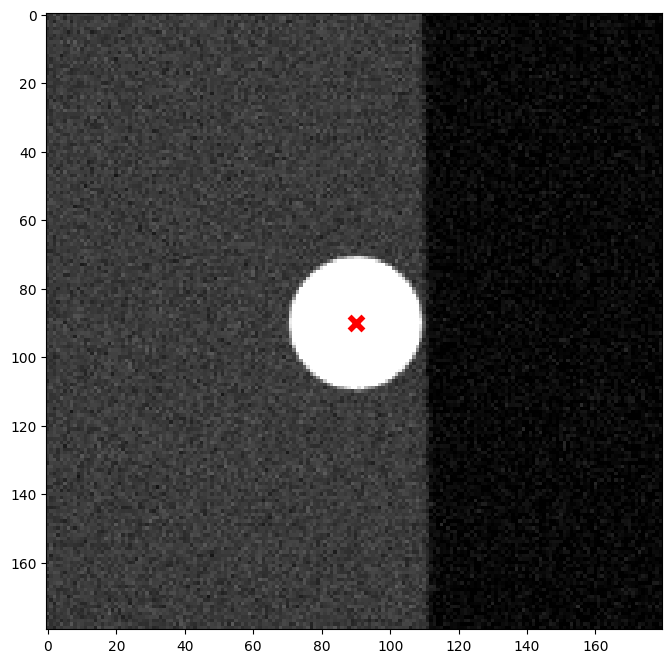

position: [90.04011624 90.08121366]/Image(array([90.04011624, 90.08121366])), gray_extent: None, cr_sigma: [18.9429678], gauss_amp: [17717.02576841], noise_sigma: [18.9429678]


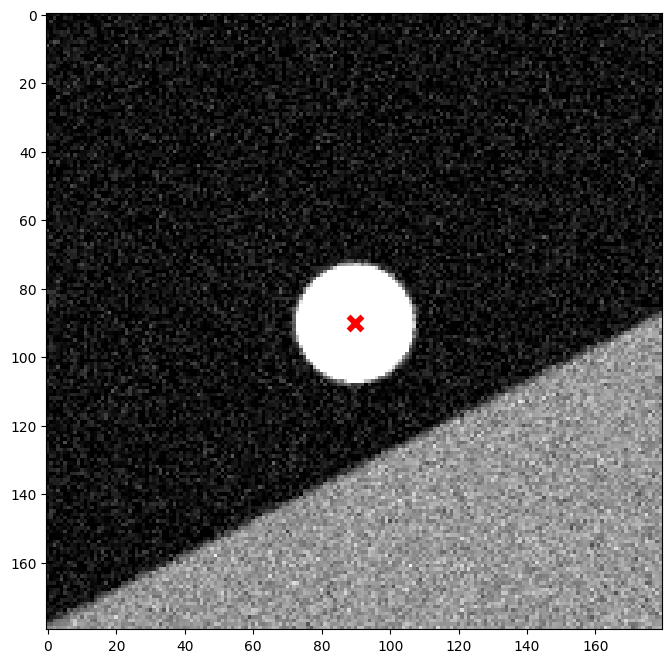

position: [89.78406522 90.14008117]/Image(array([89.78406522, 90.14008117])), gray_extent: None, cr_sigma: [16.98079022], gauss_amp: [19765.66712213], noise_sigma: [16.98079022]


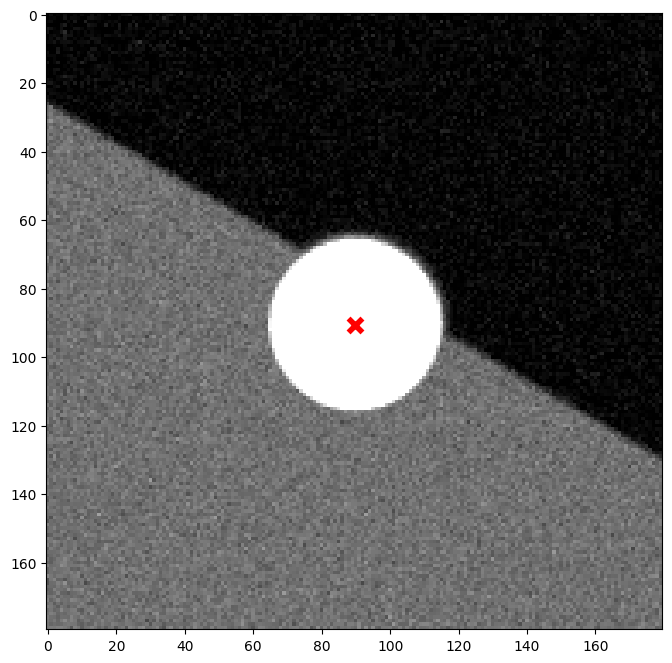

position: [89.8588965  90.51270704]/Image(array([89.8588965 , 90.51270704])), gray_extent: None, cr_sigma: [24.82282481], gauss_amp: [12045.07702223], noise_sigma: [24.82282481]


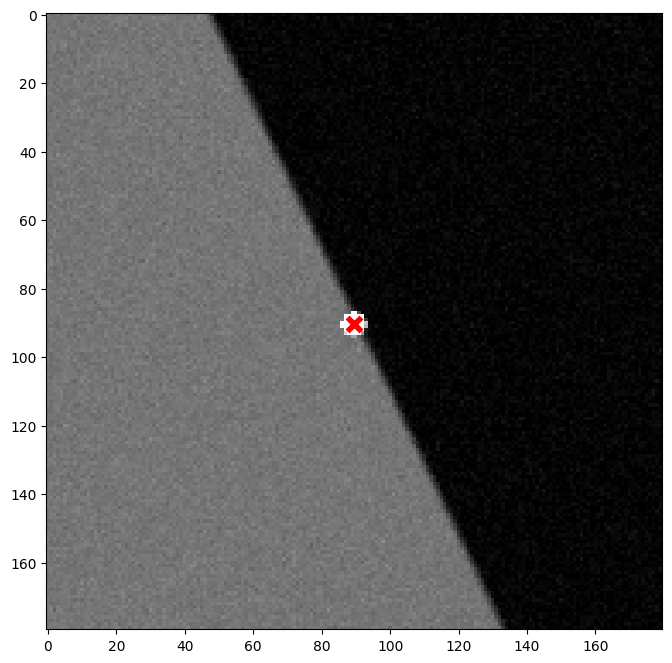

position: [89.45215612 90.42888247]/Image(array([89.45215612, 90.42888247])), gray_extent: None, cr_sigma: [3.53046542], gauss_amp: [12318.65852994], noise_sigma: [3.53046542]


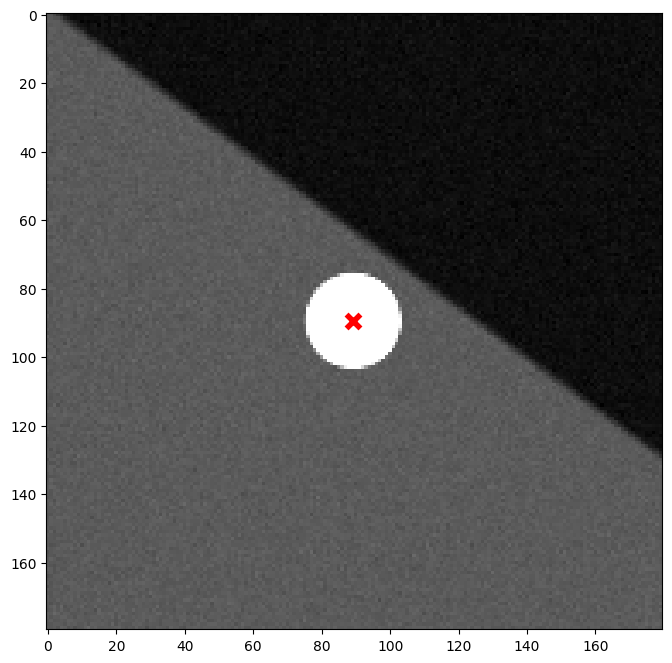

position: [89.28562381 89.4006589 ]/Image(array([89.28562381, 89.4006589 ])), gray_extent: None, cr_sigma: [13.7568413], gauss_amp: [12030.18548682], noise_sigma: [13.7568413]


In [6]:
def get_position(image):
    return np.array(image.get_property("position"))

# make data pipeline: image + labels
data_pipeline = image_pipeline & (image_pipeline >> get_position)

# test data pipeline
for p in range(5):
    output_image,position = data_pipeline.update()()
    plt.imshow(output_image, cmap='gray', vmin=0, vmax=1)
    plt.scatter(position[0], position[1], c="r", s=100, linewidths=4, marker="x")
    plt.show()

    print(f'position: {output_image.get_property("position")}/{position}, gray_extent: {output_image.get_property("extent")}, cr_sigma: {output_image.get_property("cr_sigma")}, gauss_amp: {output_image.get_property("gauss_amp")}, noise_sigma: {output_image.get_property("sigma")}')

# Transfer training

In [ ]:
# compile=False because compiled later down below
trained_model = keras.models.load_model('stage_1.h5', compile=False)
trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      640       
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                             

In [ ]:
def freeze_layers(model, layer_indices):
    """
    Freezes the layers with the given indices in a Keras model.

    :param model: The Keras model.
    :param layer_indices: A list of layer indices or a slice object to freeze.
    """
    if isinstance(layer_indices, slice):
        start, stop, step = layer_indices.indices(len(model.layers))
        layer_indices = range(start, stop, step)
    for i, layer in enumerate(model.layers):
        if i in layer_indices:
            layer.trainable = False
            print(f"Layer '{layer.name}' frozen.")
        else:
            layer.trainable = True
            print(f"Layer '{layer.name}' unfrozen.")

In [ ]:
# Freeze the last layer
freeze_layers(trained_model, slice(None, 3))

Layer 'input_1' frozen.
Layer 'conv2d' frozen.
Layer 'activation' frozen.
Layer 'conv2d_1' frozen.
Layer 'activation_1' frozen.
Layer 'max_pooling2d' frozen.
Layer 'conv2d_2' unfrozen.
Layer 'activation_2' unfrozen.
Layer 'conv2d_3' unfrozen.
Layer 'activation_3' unfrozen.
Layer 'max_pooling2d_1' unfrozen.
Layer 'conv2d_4' unfrozen.
Layer 'activation_4' unfrozen.
Layer 'conv2d_5' unfrozen.
Layer 'activation_5' unfrozen.
Layer 'max_pooling2d_2' unfrozen.
Layer 'conv2d_6' unfrozen.
Layer 'activation_6' unfrozen.
Layer 'conv2d_7' unfrozen.
Layer 'activation_7' unfrozen.
Layer 'max_pooling2d_3' unfrozen.
Layer 'conv2d_8' unfrozen.
Layer 'activation_8' unfrozen.
Layer 'conv2d_9' unfrozen.
Layer 'activation_9' unfrozen.
Layer 'max_pooling2d_4' unfrozen.
Layer 'conv2d_10' unfrozen.
Layer 'activation_10' unfrozen.
Layer 'conv2d_11' unfrozen.
Layer 'activation_11' unfrozen.
Layer 'max_pooling2d_5' unfrozen.
Layer 'conv2d_12' unfrozen.
Layer 'activation_12' unfrozen.
Layer 'conv2d_13' unfrozen.


In [ ]:
# Define early-stopping:
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='val_pixel_error',
    min_delta = 0.0001,
    verbose=1,
    patience=20,
    mode="min",
    restore_best_weights=True)

In [ ]:
# Function that retrieves the position of a particle
# and divides it by Image size to get values between 0 and 1
def get_scaled_position_of_particle(image):
    return image.get_property("position") / IMAGE_SIZE

In [ ]:
lr = 1e-6
# Building an optimiser
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True)

opt = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [ ]:
def scaled_pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1)))
def pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1))) * IMAGE_SIZE

In [ ]:
trained_model.compile(optimizer=opt, loss="mse", metrics=[pixel_error,scaled_pixel_error] )

Generating 1057 / 1000 samples before starting training
Epoch 1/700
250/250 [==============================] - 15s 18ms/step - loss: 7.2934e-07 - pixel_error: 0.1778 - scaled_pixel_error: 9.8772e-04 - val_loss: 6.5035e-07 - val_pixel_error: 0.1675 - val_scaled_pixel_error: 9.3052e-04
Epoch 2/700
250/250 [==============================] - 3s 13ms/step - loss: 6.2266e-07 - pixel_error: 0.1595 - scaled_pixel_error: 8.8629e-04 - val_loss: 5.5837e-07 - val_pixel_error: 0.1540 - val_scaled_pixel_error: 8.5537e-04
Epoch 3/700
250/250 [==============================] - 3s 12ms/step - loss: 5.9306e-07 - pixel_error: 0.1553 - scaled_pixel_error: 8.6259e-04 - val_loss: 7.4085e-07 - val_pixel_error: 0.1917 - val_scaled_pixel_error: 0.0011
Epoch 4/700
250/250 [==============================] - 3s 12ms/step - loss: 4.9649e-07 - pixel_error: 0.1461 - scaled_pixel_error: 8.1153e-04 - val_loss: 4.6668e-07 - val_pixel_error: 0.1443 - val_scaled_pixel_error: 8.0153e-04
Epoch 5/700
250/250 [==============

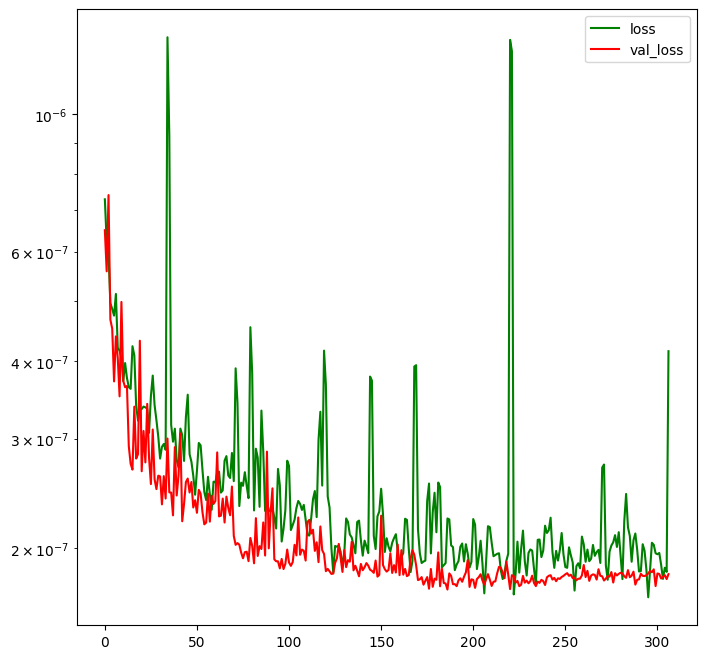

In [ ]:
validation_set_size = 300
validation_set    = [image_pipeline.update()() for _ in range(validation_set_size)]
validation_labels = [get_scaled_position_of_particle(image) for image in validation_set]

generator = dt.generators.ContinuousGenerator(
    image_pipeline,
    get_scaled_position_of_particle,
    min_data_size=int(1e3),
    max_data_size=int(2e4),
    batch_size=4,
    max_epochs_per_sample=1
)

with generator:
    h = trained_model.fit(
        generator,
        validation_data=(
            np.array(validation_set),
            np.array(validation_labels)
        ),
        epochs=700,
            callbacks = EARLY_STOPPING,
            shuffle=True
    )

plt.plot(h.history["loss"], 'g')
plt.plot(h.history["val_loss"], 'r')
plt.legend(["loss", "val_loss"])
plt.yscale('log')
plt.show()

In [ ]:
# Model save
trained_model.save('stage_2.h5')